## ML MIPT Practical 3

### 0. Введение и план

В данном домашнем задании будем решать задачу классификации отзывов.

Шаги решения:

1. Извлечение признаков: код для создания TF-IDF матрицы из представленного корпуса отзывов
2. Обучение моделей: код для обучения SVM и логистической регрессии
3. Кросс-валидация для подбора гиперпараметров: код для оптимизации метрик обучения
4. Участие в контесте на kaggle.com

#### Подготовка

Сперва импортируем нужные библиотеки и определим функцию res_matrix, которая по y_pred для каждого сэмпла будет выдавать соответствующее константное распределение.

In [11]:
import random
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from random import shuffle
from cs231n.classifiers.linear_classifier import Softmax, LinearSVM
from IPython.display import Image
from cs231n.classifiers.linear_svm import svm_loss_naive, svm_loss_vectorized
from cs231n.classifiers.softmax import softmax_loss_naive, softmax_loss_vectorized
from cs231n.gradient_check import grad_check_sparse
from sklearn.metrics import classification_report, log_loss
from sklearn.cross_validation import train_test_split


%matplotlib inline
mpl.rc("savefig", dpi=300)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def res_matrix(pred):
    """Returns constant distribution for each element of pred."""
    results_matrix = np.zeros((len(pred), 4))
    results_matrix[np.arange(len(pred)), pred] = 1
    return results_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Считываем и знакомимся с данными

In [4]:
data = pd.read_csv('kaggle_data/train.csv', index_col=0, na_values='NaN')
print("Data shape is" + str(data.shape))
print(data.head())
documents = data["Reviews_Summary"].values
score = data["Prediction"].values
ids = data.index.values

Data shape is(352278, 2)
                                          Reviews_Summary  Prediction
ID                                                                   
230872                                  Babies love these           3
344823                                       Salmon Trout           0
211754                                     disappointment           1
259421  Doesn't taste like Cinnabon; tastes like Waffl...           2
253418  Delicious San Daniele prosciutto and good cust...           3


Как видите, каждый объект представляет собой отзыв о продукте и оценку по шкале от 0 до 3. Выдвинем гипотезу, что слова, используемые в написании отзыва коррелируют с оценкой, которая была поставлена. Поставим задачу - предсказать оценку по тексту отзыва.

### 1. Извлечение признаков - 10 Баллов
 

Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координает равно количеству раз, слово используется в документе. 

Для решения данной задачи нам нужно написать код, который преобразовывает документы в численную матрицу.

Дополнительная информация:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Используем данный трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Сначала воспользуемся CountVectorizer чтобы превратить предложения в вектора. Затем посчитаем распределение частотности слов. Заметим, что мы передели CountVectorizer параметр stop_words='english', поэтому все английские стоп слова будут выкинуты.

Total num words: 26798


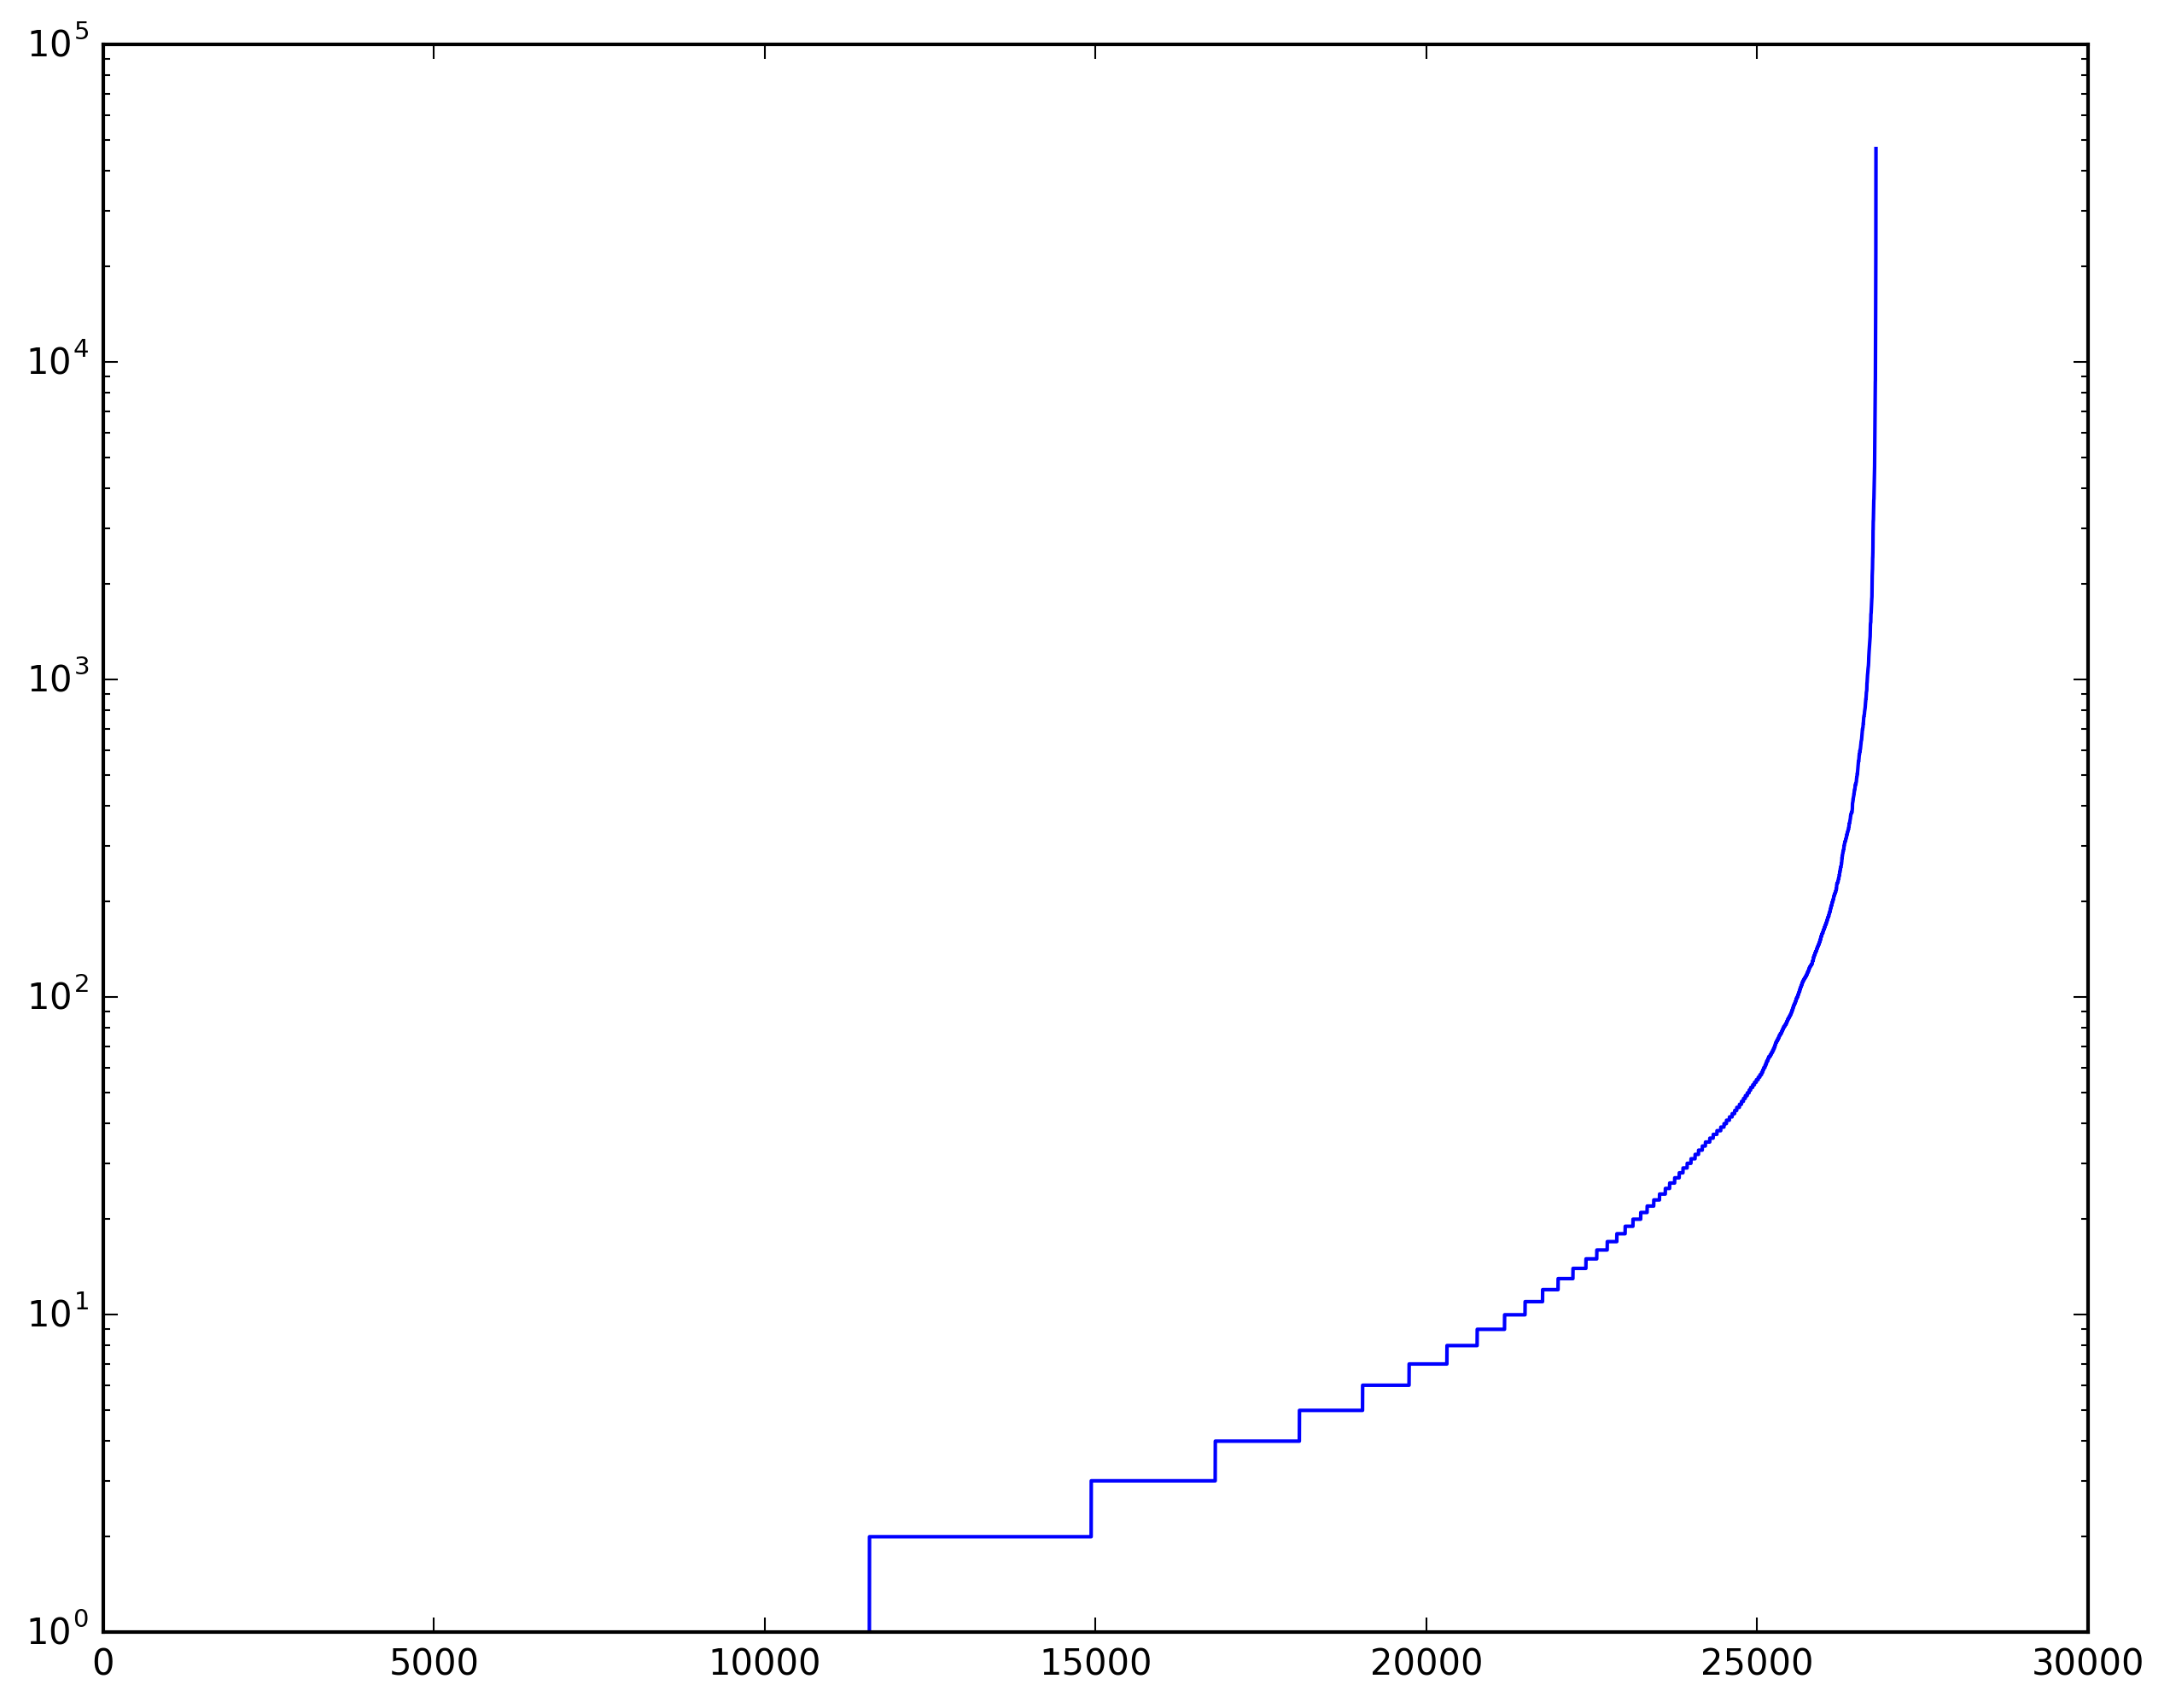

In [6]:
vectorizer = CountVectorizer(min_df=1, stop_words='english')
documents_vectorized = vectorizer.fit_transform(documents)
print("Total num words: %d" % documents_vectorized.shape[1])
d = dict()
for sentence in map(vectorizer.build_analyzer(), documents):
    for word in sentence:
        if word not in d:
            d[word] = 0
        d[word] += 1
plt.plot(sorted(list(d.values())))
plt.yscale('log')

Как видно всего слов получилось 26798, но большая их часть встреается в тексте предложении суммарно меньше 10 раз, поэтому можно оставить только 4000 значимых слов (max_features=4000).

Для учета важности редких, но показательных слов (термов), используется схема взвешивания TF-IDF. Напишем код, принимающий на вход разреженную матрицу векторного представления документов и возвращающий разреженную матрицу документов, частоты термов которых взвешенны по TF-IDF.

Дополнительная информация:

- Подробнее про TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- Используем этот трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

В параметры TfidfTransformer передаем norm='l2', чтобы итоговые вектора были нормированны в пространстве L2

In [8]:
vectorizer = CountVectorizer(min_df=1, stop_words='english', max_features=4000)
documents_vectorized = vectorizer.fit_transform(documents)

transformer = TfidfTransformer(norm='l2')
documents_tfidf = transformer.fit_transform(documents_vectorized)

documents_tfidf = documents_tfidf.toarray()

Разобъем обучающую выборку на 2 части train и test

Используем трансформер http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split.

Транспонируем матрицы с данными, т.к. так будет проще реализовать код SVM.

In [64]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(documents_tfidf, score, np.arange(len(score)))
X_train = X_train.T
X_test = X_test.T
print("X_train shape is " + str(X_train.shape))
print("X_test shape is " + str(X_test.shape))

X_train shape is (4000, 264208)
X_test shape is (4000, 88070)


Возьмем подвыборки из обучающей выборки, для быстрой проверки кода.

In [16]:
X_train_sample = X_train[:, 0:100000]
y_train_sample = y_train[0:100000]
print("X_train_sample shape is " + str(X_train_sample.shape))

X_train_sample shape is (4000, 100000)


#### Замечание

Когда я первый раз воспользовался `train_test_split`, я использовал все $26798$ слов, вместо $4000$. Оно конечно, не сработало :), но когда я полез разбираться, я заметил, что python отобрал для себя 60 GB оперативной памяти (!), учитывая, что у меня в макбуке всего 8. Так я для себя открыл, что ядро OSX умеет сжимать память на лету, что оказалось довольно полезной фишкой, учитывая, что все мои numpy.array были разряженными. Кстати, быстрый гуглеж показал, что Microsoft в Windows 10 тоже добавила такую фичу.

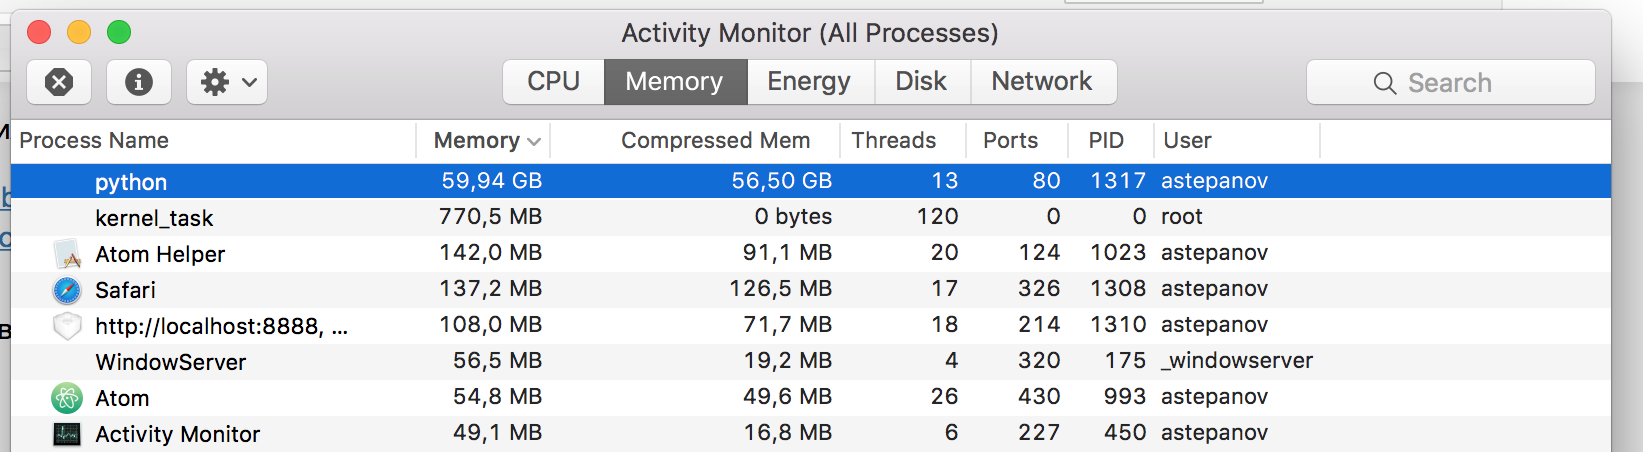

In [15]:
Image('memory_fail.png')

------

### 2. Код для SVM и логистической регресии - 40 Баллов

После того, как мы получили матрицу признаков, нам необходимо реализовать алгоритм обучения SVM и логистической регрессии. Обе модели являются линейными и отличаются функциями потерь. Для решения оптимизационных задач в обеих моделей будет использоваться стохастический градиентный спуск.

Дополнительная информация тут:

- Линейные модели: http://cs231n.github.io/linear-classify/
- SGD: http://cs231n.github.io/optimization-1

Начнем с SVM, функция потерь и вычисления градиента находятся в cs231n/classifiers/linear_svm.py.

Найдем чему равен градиент:

In [28]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01
%time loss, _ = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
print('loss: %f' % loss)

CPU times: user 4.16 s, sys: 72.3 ms, total: 4.23 s
Wall time: 3.83 s
loss: 3.000355


Реализуем наивную версию расчета градиента и проверем результат с помощью численного метода расчета. Градиенты должны почти совпадать.

In [29]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: 0.000414 analytic: 0.000414, relative error: 3.739291e-08
numerical: 0.000003 analytic: 0.000003, relative error: 8.112045e-06
numerical: 0.000122 analytic: 0.000122, relative error: 2.275272e-07
numerical: 0.000066 analytic: 0.000066, relative error: 2.079930e-07
numerical: 0.000010 analytic: 0.000010, relative error: 2.323062e-06


Теперь рализуем векторизированную версию расчета фунции потерь - svm_loss_vectorized

In [30]:
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))


tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 3.000355e+00 computed in 4.966810s
Vectorized loss: 3.000355e+00 computed in 0.839398s
difference: 0.000000


Завершим реализацию SVM векторизированной функцией подсчета градиента.

In [31]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 3.851424s
Vectorized loss and gradient: computed in 0.724998s
difference: 0.000000


Получили ускорение почти в 5 раз, хорошо.

### Stochastic Gradient Descent

Теперь заимплементим Stochastic Gradient Descent, он находится в файле cs231n/classifiers/linear_classifier.py

In [33]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-2, reg=0.01,
                      num_iters=500, verbose=True, batch_size=10000)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

iteration 0 / 500: loss 3.000483, best_loss: 3.000483
iteration 100 / 500: loss 2.668532, best_loss: 2.667927
iteration 200 / 500: loss 2.434611, best_loss: 2.409608
iteration 300 / 500: loss 2.311440, best_loss: 2.293535
iteration 400 / 500: loss 2.243755, best_loss: 2.231858
That took 331.228188s
Current loss is 2.209341


Нарисуем график loss от номера итерации, он должен быть убывающим.

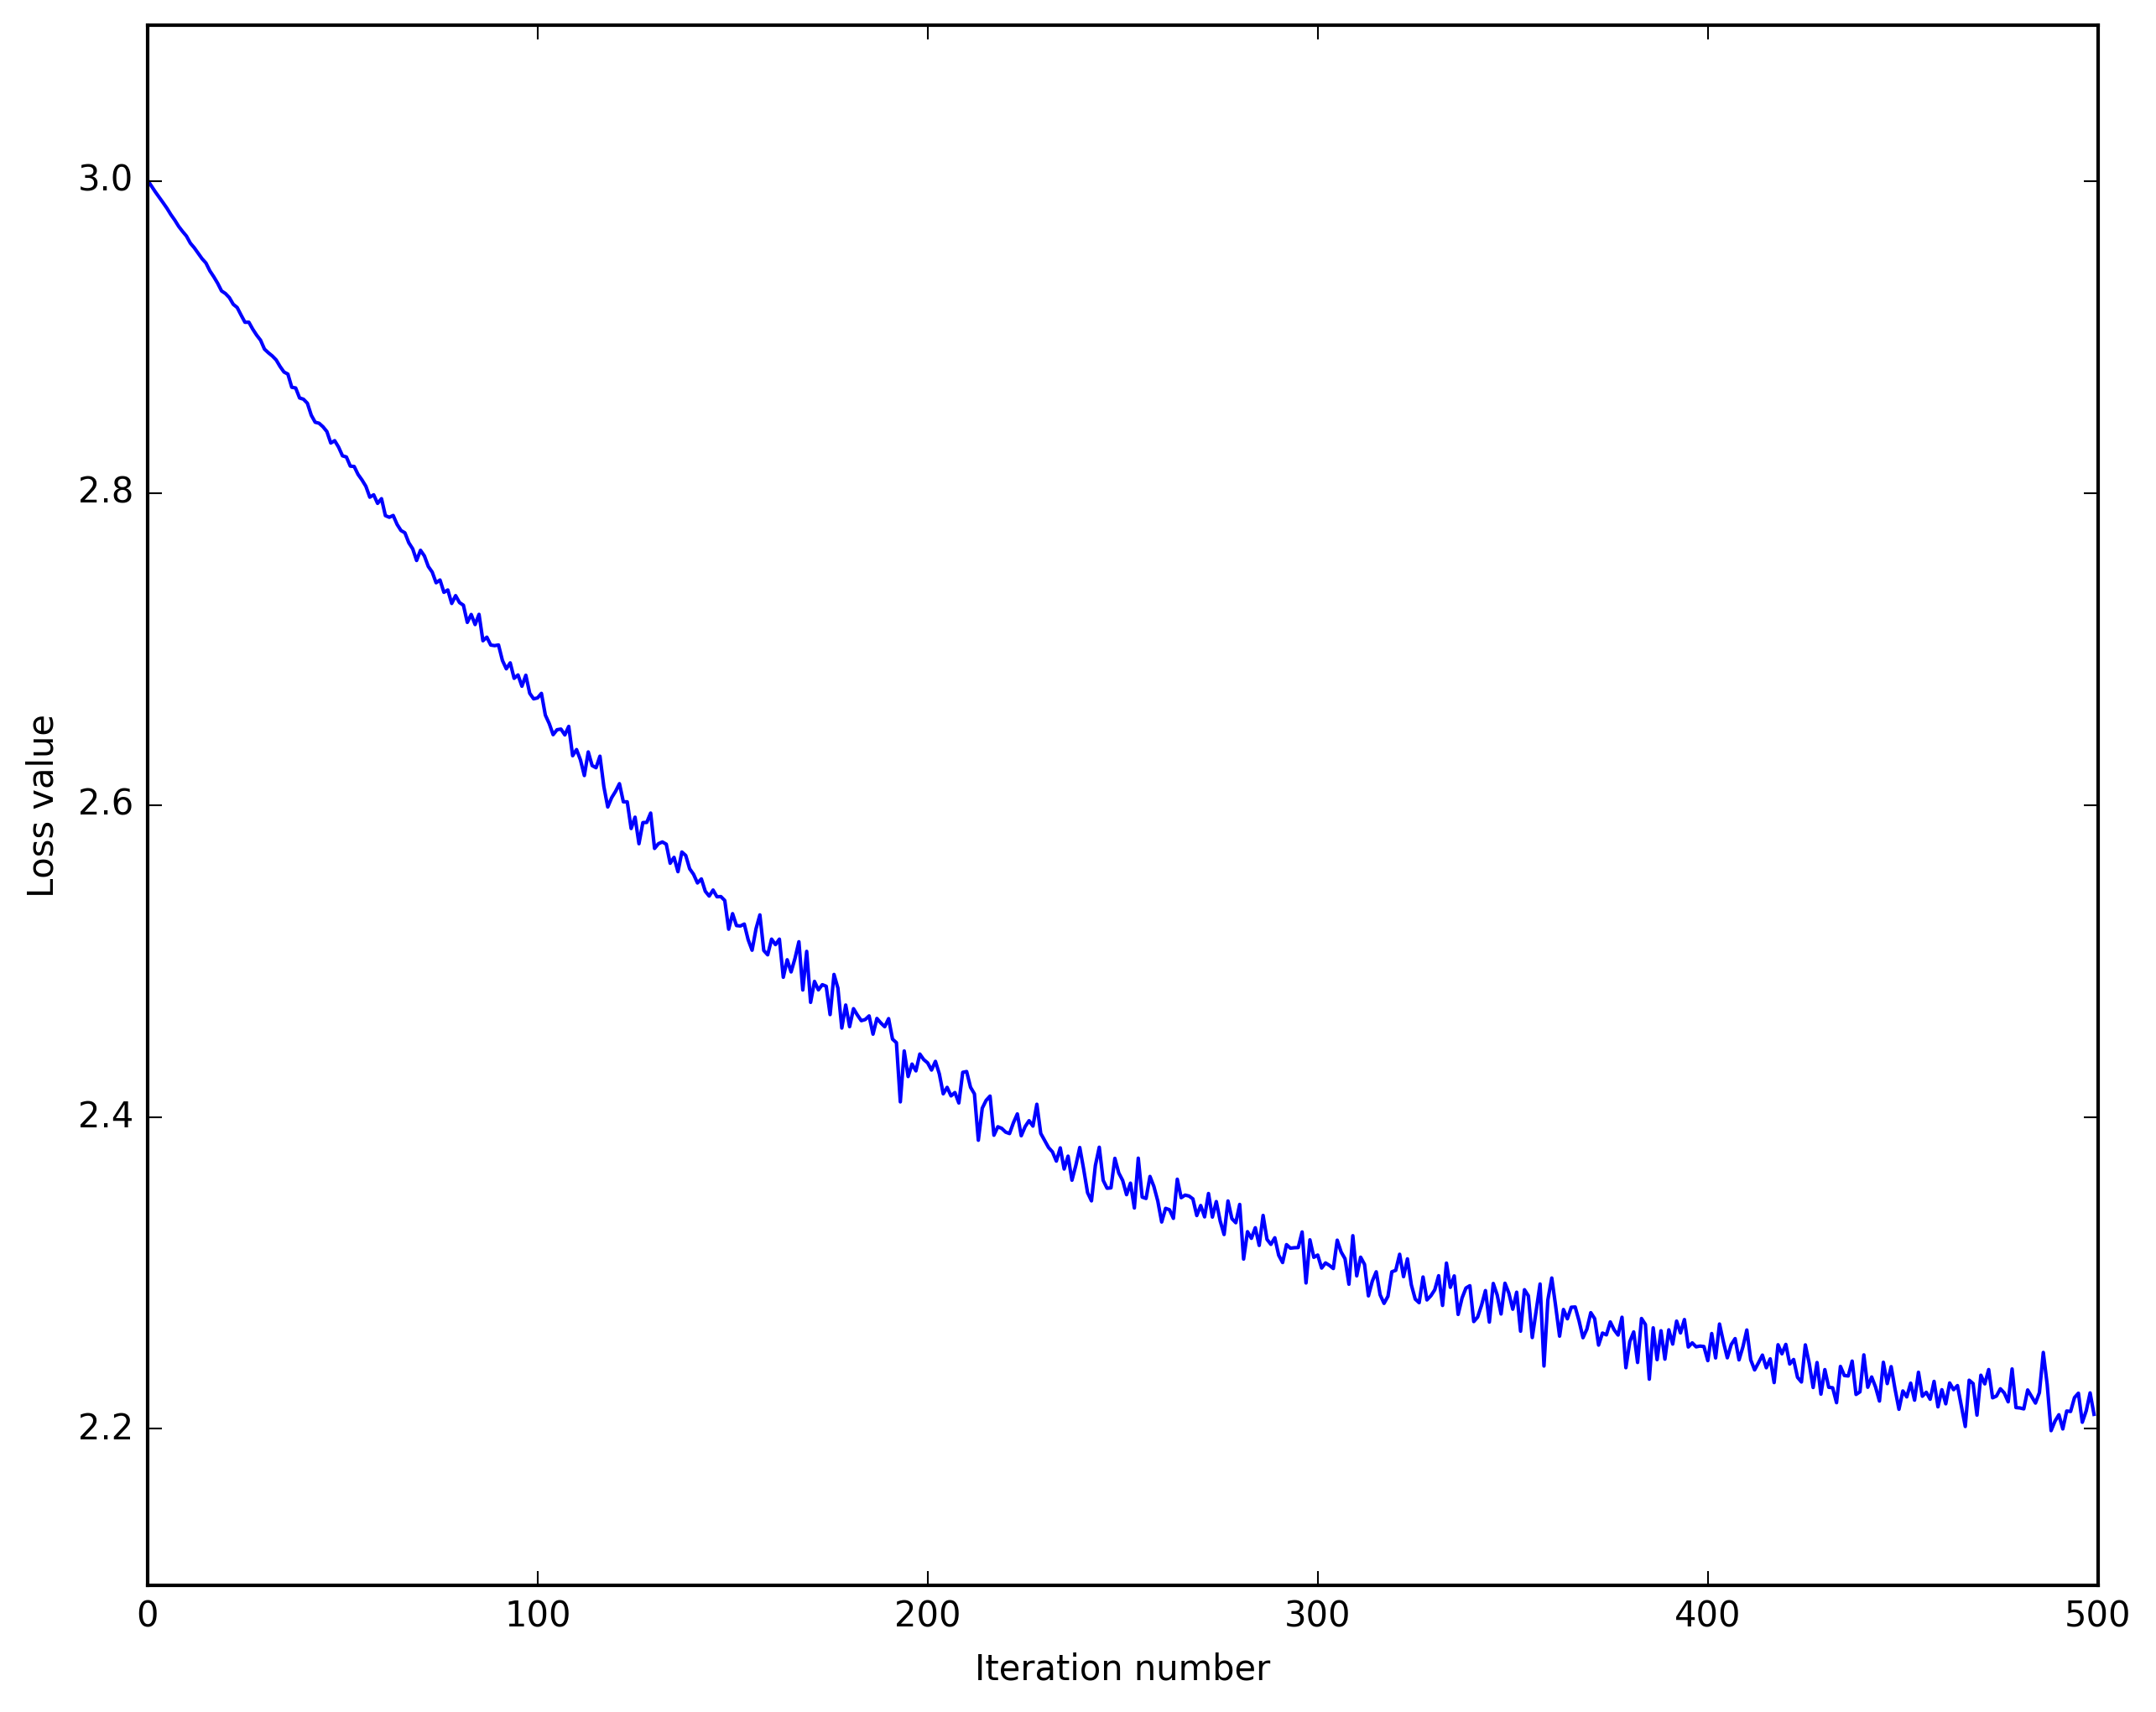

In [35]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Теперь напишем predict. Он просто перемножает матрицу весов на вектор и выбирает класс с максимальным скором.

In [38]:
y_test_pred = svm.predict(X_test)

Посмотрим на classification_report

In [33]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.46      0.30      0.37     15125
          1       0.57      0.04      0.07      8709
          2       0.35      0.01      0.02     23313
          3       0.72      0.97      0.83    105131

avg / total       0.63      0.70      0.61    152278



Можно еще сравнить с тупым классификатором, который всегда говорит 3.

In [45]:
print(classification_report(y_test, [3]*len(y_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      8641
          1       0.00      0.00      0.00      5008
          2       0.00      0.00      0.00     13495
          3       0.69      1.00      0.82     60926

avg / total       0.48      0.69      0.57     88070



/Users/astepanov/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Искомая метрика, которую нужно минимизировать в контесте на kaggle - это logloss, это условная энтропия найденного распределения классов при условии истинного (в данной задаче истинное распределение является константным, где константа равна истинному классу). Так как SVM не умеет выдавать распределеня классов, то мы в качестве распределения передадим туда константое, где константа равна предсказанному классу.

In [39]:
log_loss(y_test, res_matrix(y_test_pred))

10.182409337089371

Печально, ибо если в качестве предсказания выдавать равномерное распределение по классам, то log_loss будет равен -log(1.0/4), вот этому вот числу:

In [42]:
-math.log(1.0/4)

1.3862943611198906

То есть 1.38 вместо 10 :) Если не верите, что равномерное распределение получит так мало, то вот доказательство:

In [44]:
log_loss(y_test, [[0.25] * 4] * len(y_test))

1.3862943611198906

Из-за этой проблемы будем юзать softmax классификатор, который умеет предсказывать распредление по классам

--------

## Softmax Classifier

Поскольку мне лень писать наивную версию, я сразу написал векторизированную, и вызов наивной версии эквивалентен векторизированной. Дальше все так же, как и для SVM

In [48]:
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(4, X_train_sample.shape[0]) * 0.01 
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.25).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.25)))

loss: 1.385706
sanity check: 1.386294


In [49]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: softmax_loss_naive(w, X_train_sample, y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 5)

numerical: 0.000074 analytic: 0.000074, relative error: 4.967758e-08
numerical: 0.000016 analytic: 0.000016, relative error: 2.835710e-07
numerical: 0.000005 analytic: 0.000005, relative error: 1.040924e-07
numerical: -0.000171 analytic: -0.000171, relative error: 3.325412e-08
numerical: -0.000017 analytic: -0.000017, relative error: 4.229750e-07


In [50]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train_sample, y_train_sample, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 1.385722e+00 computed in 0.931071s
vectorized loss: 1.385722e+00 computed in 0.919189s
Loss difference: 0.000000
Gradient difference: 0.000000


Тут я убрал регуляризацию нафиг, ибо мы минимизируем квадратичную функцию с 1 глобальным экстремумом и тут не бывает оверфитинга. Еще поставил learning_rate=1, по тем же самым соображениям. Кстати, то, что выдает softmax в качестве лосса и есть log_loss на train выборке.

In [65]:
sm = Softmax()
tic = time.time()
loss_hist = sm.train(X_train, y_train, learning_rate=1, reg=0,
                      num_iters=2000, verbose=True, batch_size=1000)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

iteration 0 / 2000: loss 1.386296, best_loss: 1.386296
iteration 100 / 2000: loss 1.138133, best_loss: 1.115228
iteration 200 / 2000: loss 1.025237, best_loss: 1.003285
iteration 300 / 2000: loss 0.996043, best_loss: 0.938259
iteration 400 / 2000: loss 0.933928, best_loss: 0.926598
iteration 500 / 2000: loss 0.921429, best_loss: 0.874424
iteration 600 / 2000: loss 0.926240, best_loss: 0.864017
iteration 700 / 2000: loss 0.931294, best_loss: 0.854851
iteration 800 / 2000: loss 0.932217, best_loss: 0.848929
iteration 900 / 2000: loss 0.826433, best_loss: 0.826433
iteration 1000 / 2000: loss 0.881209, best_loss: 0.819051
iteration 1100 / 2000: loss 0.858659, best_loss: 0.819051
iteration 1200 / 2000: loss 0.837933, best_loss: 0.799393
iteration 1300 / 2000: loss 0.841265, best_loss: 0.789904
iteration 1400 / 2000: loss 0.820394, best_loss: 0.789904
iteration 1500 / 2000: loss 0.813585, best_loss: 0.788853
iteration 1600 / 2000: loss 0.796915, best_loss: 0.788853
iteration 1700 / 2000: los

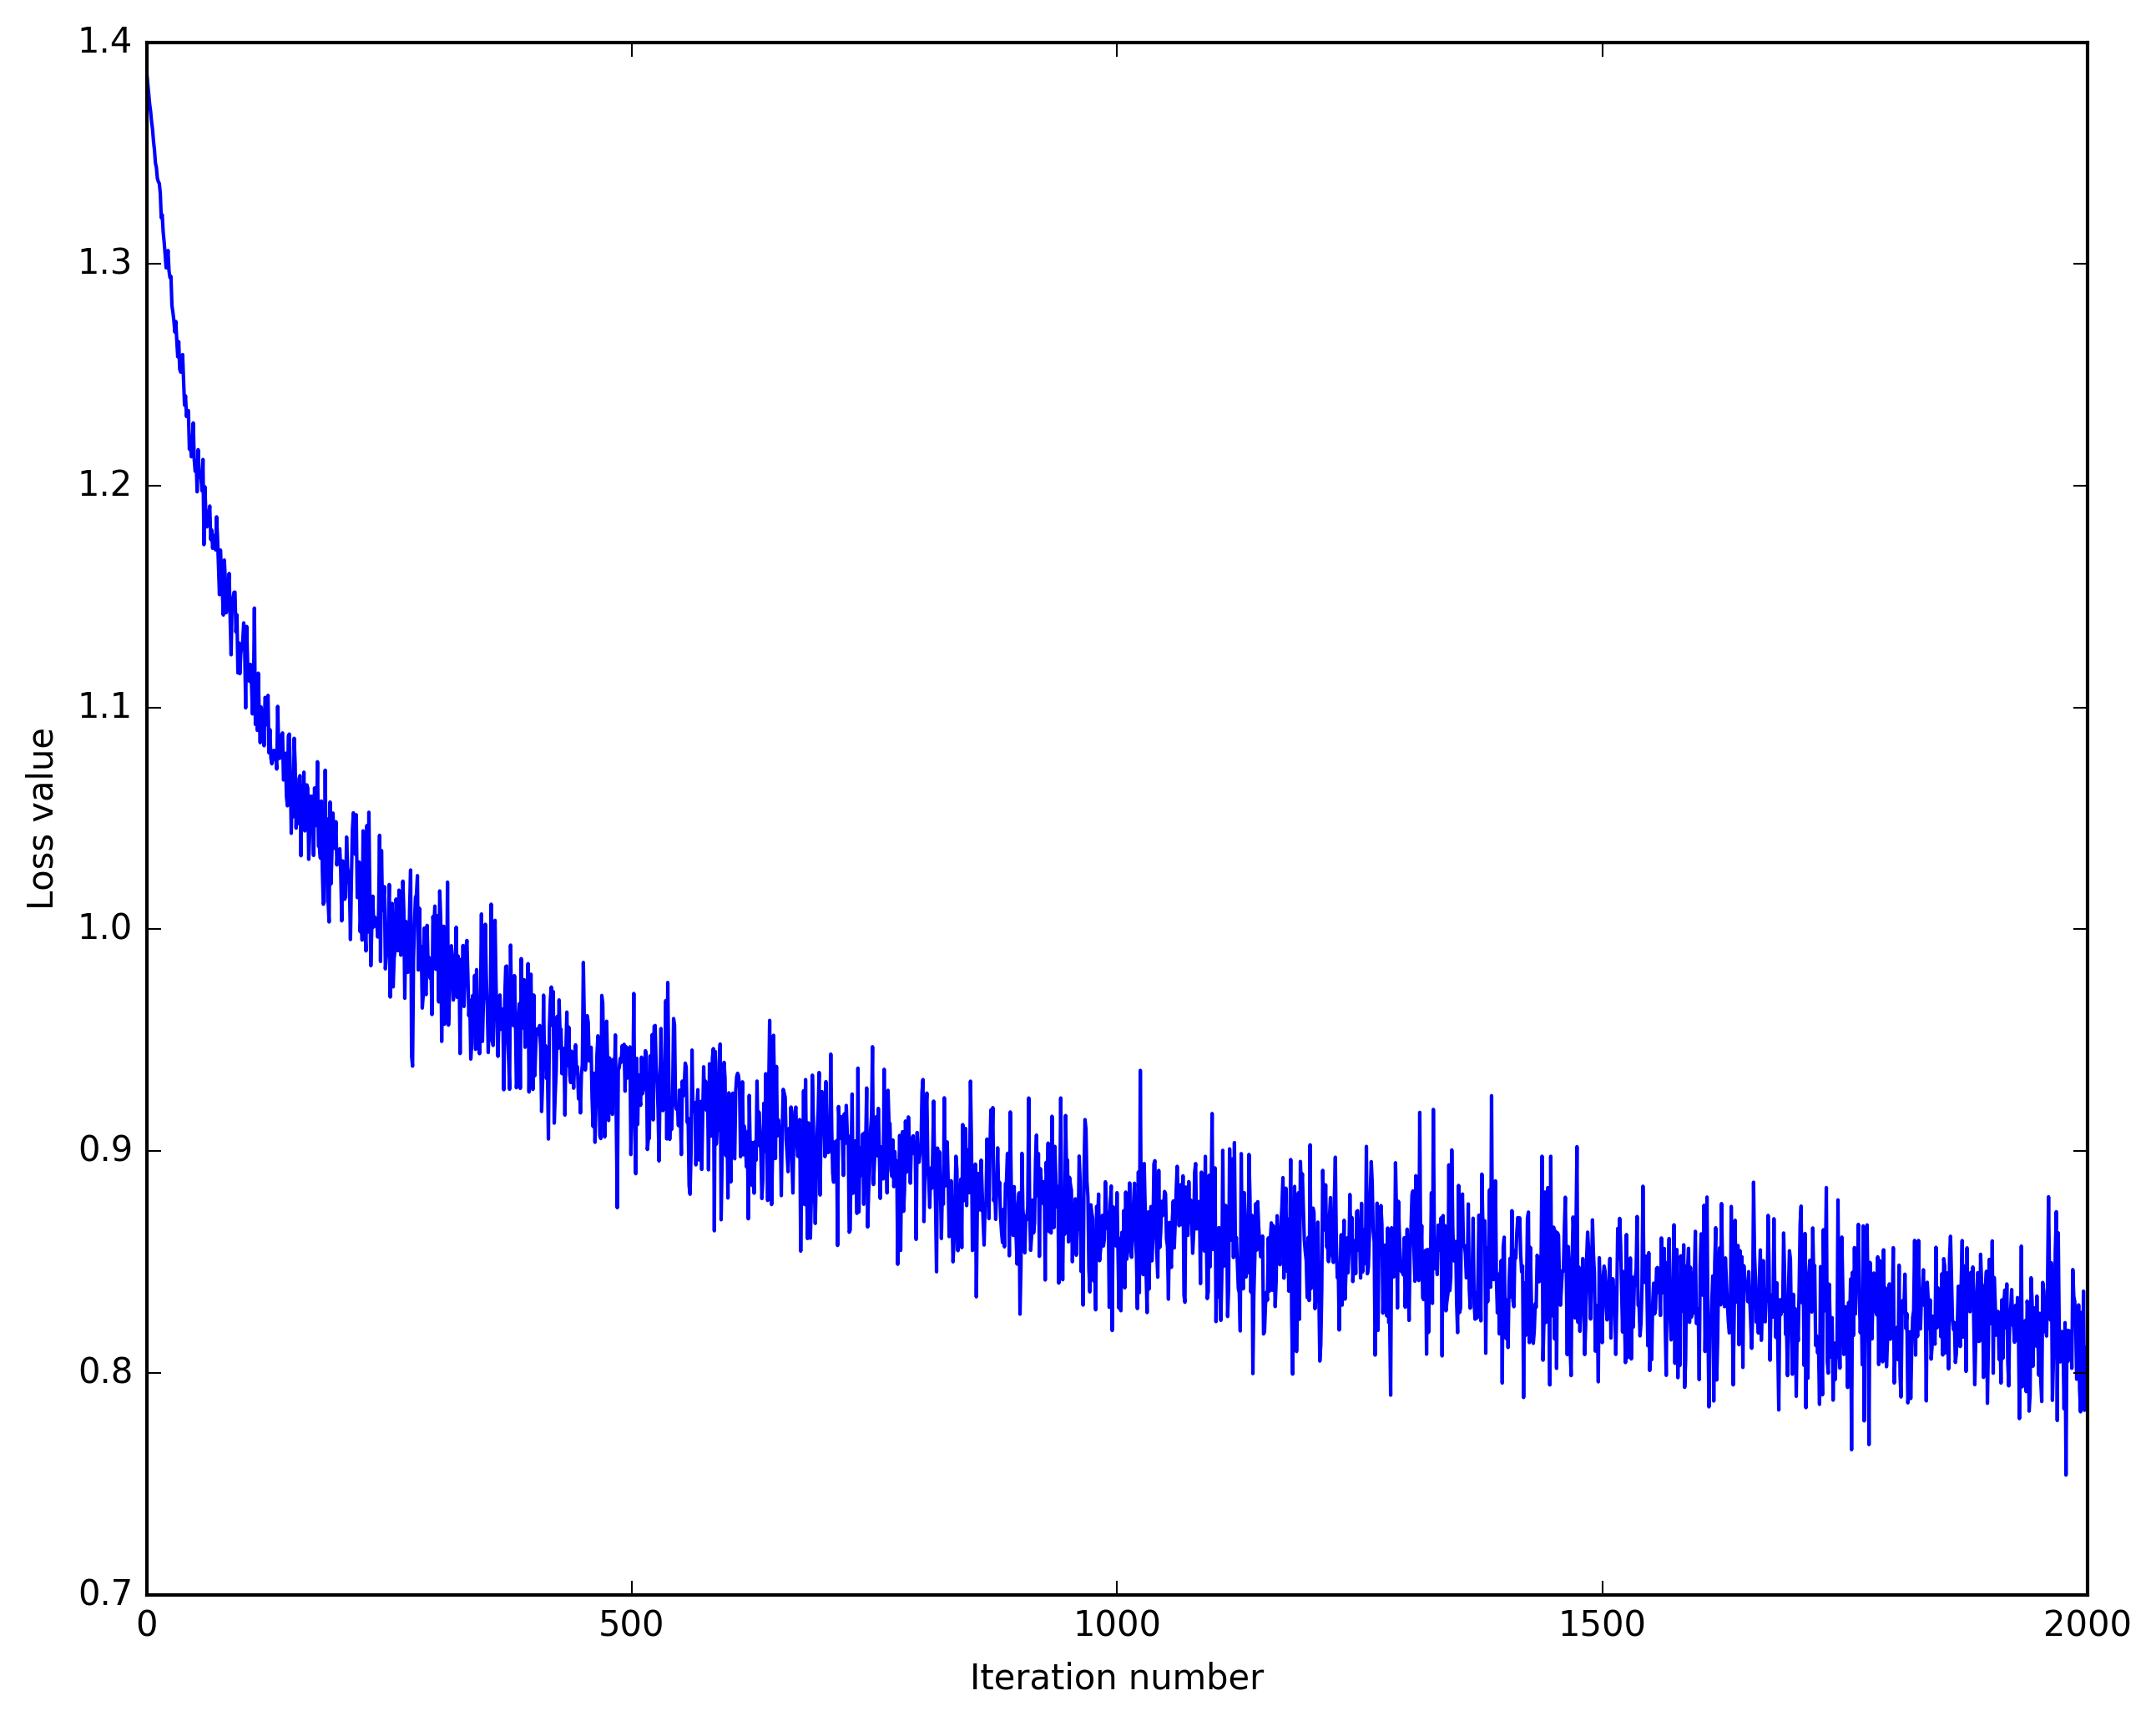

In [66]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [67]:
y_test_pred = sm.predict(X_test)

In [68]:
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       0.52      0.44      0.48      8904
          1       0.47      0.07      0.13      4916
          2       0.52      0.07      0.12     13604
          3       0.75      0.96      0.84     60646

avg / total       0.67      0.72      0.65     88070



Еще написал predict_prob, который выдает распределение по классам.

In [69]:
y_test_prob = sm.predict_prob(X_test)
log_loss(y_test, y_test_prob.T)

0.82371849788696672

Уже лучше, чем $log(4)$

In [107]:
print("{:<5}{:<80}{:<30}".format("True", "Sentence", "Distribution"))
for i in range(200):
    if len(documents[idx_test[i]]) > 80:
        continue
    print("{:<5}{:<80}{:<30}".format(y_test[i], documents[idx_test[i]], ('%.2f '*4)%tuple(y_test_prob.T[i])))

True Sentence                                                                        Distribution                  
3    SIMPLY THE BEST                                                                 0.01 0.02 0.03 0.94           
3    jerky is yummy                                                                  0.04 0.04 0.16 0.76           
3    Techno-BEST                                                                     0.00 0.00 0.00 1.00           
1    Didn't really enjoy them                                                        0.26 0.24 0.17 0.33           
3    Celestial Seasonings Wellness Tea Echinacea, helped Cure my Hay Fever...!       0.15 0.14 0.20 0.52           
3    It's like a fiery punch in the mouth, but DELICIOUS!                            0.07 0.06 0.18 0.70           
2    Yummy -- but not what I was expecting                                           0.08 0.10 0.23 0.59           
3    Kitties Love It!                                                   

Как видим, на простых предложениях классификатор работает очень хорошо.

С иронией все плохо, классификатор подумал, что если клиент написал, что чипсы оказались хорошей едой для мышей (`Kettle Chips Make Great Mouse Food`), то клиент доволен (на самом деле нет). Тут сказывается простота классификатора и модели bag of words, ведь если переставить слова `kettle mouse chips make great food [for them]`, то смысл у предложения получиться совсем другой.

------

### 3. Kaggle In Class - 50 Баллов

Я решил не использовать кросс валидацию по двум причинам:
* Если перебирать все параметры (особенно max_features, num_iters и batch_size), то обучение может затянутся.
* Модель линейная, а loss function выпуклая, как следствие, у нее всего лишь один глобальный минимум, поэтому нам не нужна регуляризация (она будет нам мешать и может поменять глобальный минимум), learning rate как показала практика можно выставить большим (1-100), поэтому будет использовать большое значение, чтобы добиться быстрой сходимости, num_iters не сильно влияет на ответ после попадания в область глобального минимума, а batch_size обычно не ищут с помощью кросс валидации, а ставят небольшое значение, степень двойки.

Также я решил запомнить в градиентном спуске на каком W был достигнут глобальный минимум loss, вместо того, чтобы запоминать только последний. Это полезно, когда диспресия loss большая из-за маленького batch_size и не всегда последний ответ является лучшим.

In [98]:
sm = Softmax()
tic = time.time()
loss_hist = sm.train(documents_tfidf.T, score, learning_rate=10, reg=0,
                      num_iters=2000, verbose=True, batch_size=1024)

toc = time.time()
print('That took %fs' % (toc - tic))
print('Current loss is %f' % loss_hist[-1])

iteration 0 / 2000: loss 1.386206, best_loss: 1.386206
iteration 100 / 2000: loss 0.867782, best_loss: 0.848205
iteration 200 / 2000: loss 0.822951, best_loss: 0.789862
iteration 300 / 2000: loss 0.785929, best_loss: 0.748657
iteration 400 / 2000: loss 0.804135, best_loss: 0.740425
iteration 500 / 2000: loss 0.772179, best_loss: 0.711893
iteration 600 / 2000: loss 0.767555, best_loss: 0.697810
iteration 700 / 2000: loss 0.754197, best_loss: 0.695950
iteration 800 / 2000: loss 0.742817, best_loss: 0.688809
iteration 900 / 2000: loss 0.766666, best_loss: 0.660625
iteration 1000 / 2000: loss 0.751560, best_loss: 0.660625
iteration 1100 / 2000: loss 0.722997, best_loss: 0.653541
iteration 1200 / 2000: loss 0.726523, best_loss: 0.653541
iteration 1300 / 2000: loss 0.701975, best_loss: 0.653541
iteration 1400 / 2000: loss 0.693678, best_loss: 0.651842
iteration 1500 / 2000: loss 0.686042, best_loss: 0.651842
iteration 1600 / 2000: loss 0.693980, best_loss: 0.651842
iteration 1700 / 2000: los

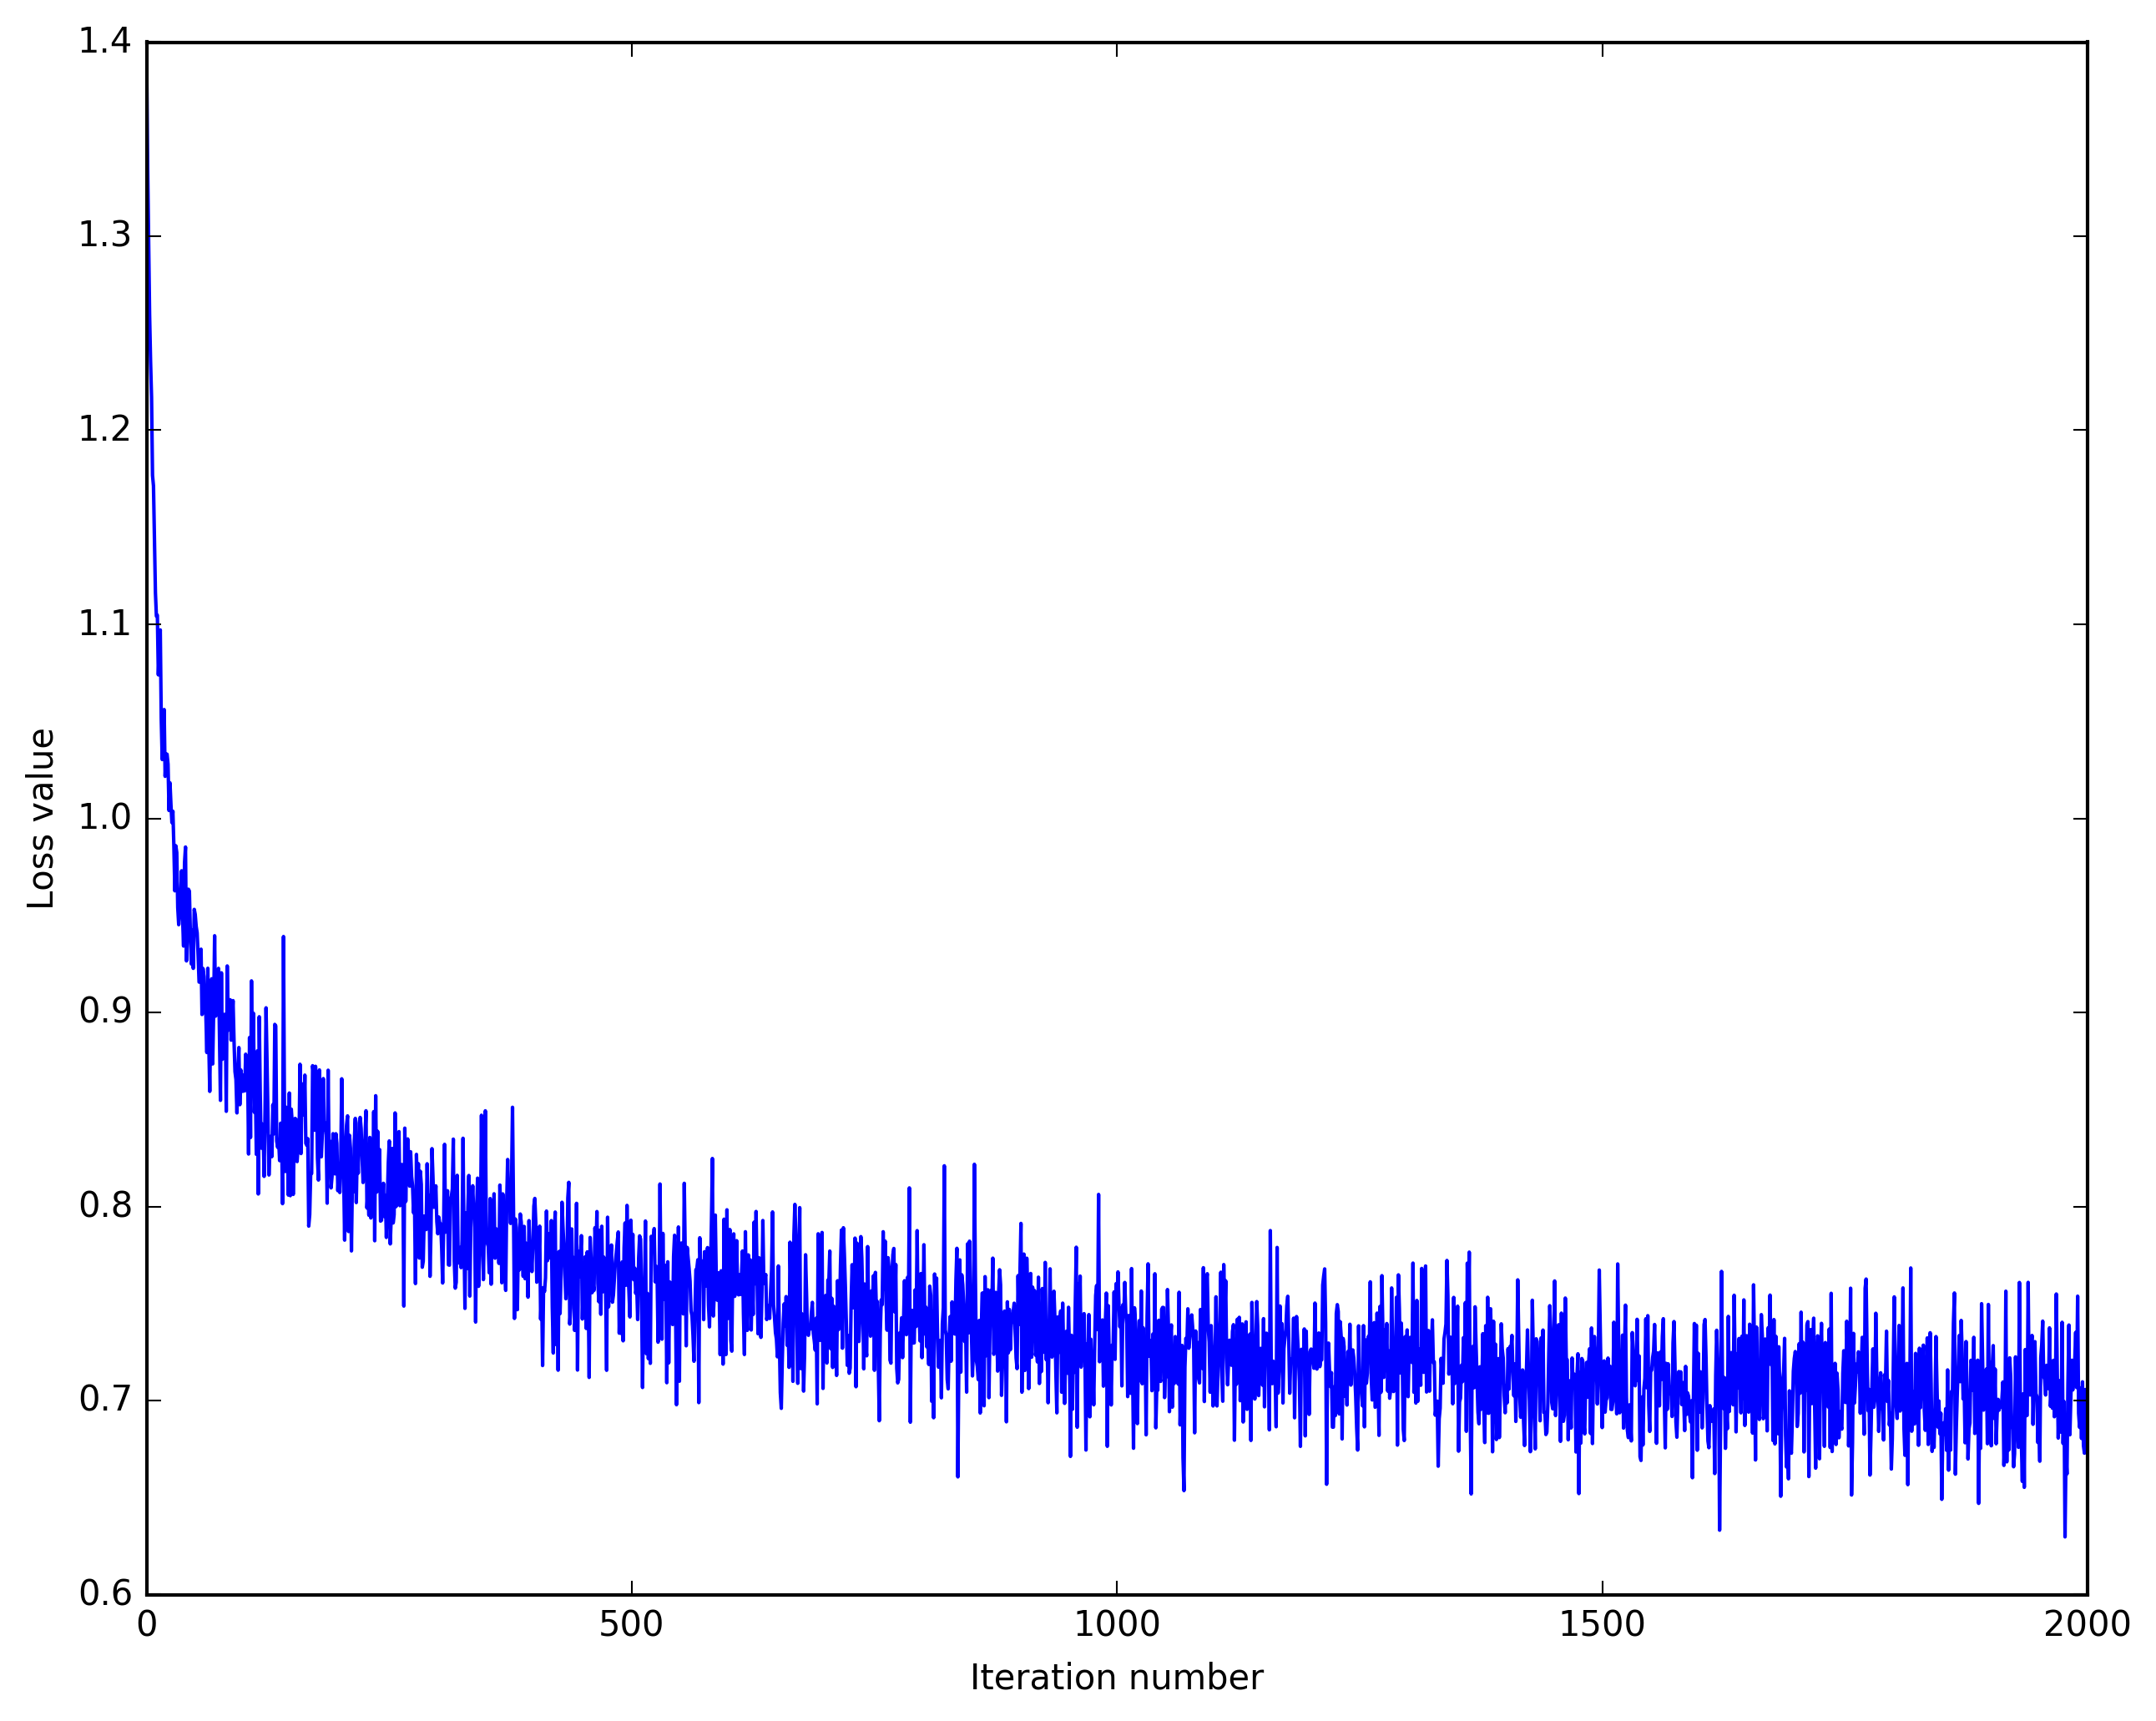

In [100]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [101]:
test = pd.read_csv('kaggle_data/test.csv', index_col=0, na_values='NaN')
documents_test = test["Reviews_Summary"].values
ids_test = test.index.values.reshape((-1,))
test_array = transformer.transform(vectorizer.transform(documents_test)).toarray()
pred = sm.predict_prob(test_array.T)
results_matrix = pred.T
ans = pd.DataFrame(results_matrix)
ans.index = ids_test
ans.index.name="Id"
ans.columns=["class_0", "class_1", "class_2", "class_3"]
ans.to_csv('kaggle_data/output.csv')

In [106]:
print("{:<80}{:<30}".format("Sentence", "Distribution"))
for i in range(30):
    if len(documents_test[i]) > 80:
        continue
    print("{:<80}{:<0}".format(documents_test[i], ('%.2f '*4)%tuple(pred.T[i])))

Sentence                                                                        Distribution                  
CHECK THE SUGAR                                                                 0.32 0.18 0.20 0.30 
Great Product                                                                   0.00 0.01 0.10 0.89 
This stuff rocks!                                                               0.03 0.01 0.04 0.92 
community coffee                                                                0.13 0.13 0.26 0.48 
Not my favorite but good for you!                                               0.00 0.01 0.09 0.90 
Great stuff                                                                     0.00 0.00 0.06 0.94 
8 out of the 12 cans were seriously dented                                      0.54 0.19 0.09 0.18 
So Peachy                                                                       0.21 0.21 0.23 0.35 
Great caffeine laden tea                                                        0